# Import Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots

import tensorflow as tf

import json
from sklearn.model_selection import train_test_split
from collections import Counter
import re

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from scipy.sparse import csr_matrix

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\brand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Ingestion

In [3]:
base_path = './'

X_train_idx = np.load(os.path.join(base_path, 'oversampled_data/over_train_indices.npy'))
# X_train_over = np.load(os.path.join(base_path, 'oversampled_data/over_X_train.npy'))
Y_train_year_over = np.load(os.path.join(base_path, 'oversampled_data/over_Y_train_year.npy'))
Y_train_make_over = np.load(os.path.join(base_path, 'oversampled_data/over_Y_train_make.npy'))
Y_train_model_over = np.load(os.path.join(base_path, 'oversampled_data/over_Y_train_model.npy'))
# Y_train_combined_over = np.load(os.path.join(base_path, 'oversampled_data/over_Y_train_combined'))

X_val_idx = np.load(os.path.join(base_path, 'oversampled_data/val_indices.npy'))
# X_val = np.load(os.path.join(base_path, 'oversampled_data/X_val.npy'))
Y_val_year = np.load(os.path.join(base_path, 'oversampled_data/Y_val_year.npy'))
Y_val_make = np.load(os.path.join(base_path, 'oversampled_data/Y_val_make.npy'))
Y_val_model = np.load(os.path.join(base_path, 'oversampled_data/Y_val_model.npy'))
# # Y_val_combined = np.load(os.path.join(base_path, 'oversampled_data/Y_val_combined'))

X_test_idx = np.load(os.path.join(base_path, 'oversampled_data/test_indices.npy'))
# X_val = np.load(os.path.join(base_path, 'oversampled_data/X_test.npy'))
Y_test_year = np.load(os.path.join(base_path, 'oversampled_data/Y_test_year (1).npy'))
Y_test_make = np.load(os.path.join(base_path, 'oversampled_data/Y_test_make (1).npy'))
Y_test_model = np.load(os.path.join(base_path, 'oversampled_data/Y_test_model (1).npy'))
# # Y_val_combined = np.load(os.path.join(base_path, 'oversampled_data/Y_test_combined'))

In [4]:
item_data_path = './data/items.csv'
item_tags_data_path = './data/tags.csv'
item_desc_data_path = './data/desc.csv'
fitment_train_data_path = './data/ftmnt_train.csv'
tabular_data_path = './data/final_df.csv'

# Load the datasets
item_desc_data = pd.read_csv(item_desc_data_path)
item_data = pd.read_csv(item_data_path)
item_tags_data = pd.read_csv(item_tags_data_path)
fitment_train_data = pd.read_csv(fitment_train_data_path)
tabular_data=pd.read_csv(tabular_data_path)

In [5]:
merged_data = item_desc_data.merge(fitment_train_data, on='RECORD_ID', how='left')
merged_data = merged_data.merge(tabular_data, on='RECORD_ID', how='left')

In [6]:
# Define a function to concatenate fields into a single string
def concatenate_fields(row):
    parts = [
        f"Title: {row['ITEM_TITLE']}",
        f"OEM Part Number: {row.get('ManufacturePartNumber', [])}",
        f"Part Title: {row.get('Part Title', [])}",
        f"Part Brands: {row.get('Part Brands', [])}",
        f"SubType: {row.get('SubType', [])}",
        f"Part Types: {row.get('Part Types', [])}",
        f"Brand: {row.get('Brand', [])}",
        f"Make: {row['Make']}",
        f"Model: {row['Model']}",
        f"Year: {row.get('Year', [])}",
        f"SKU: {row.get('SKU', [])}",
        f"Cleaned_DESC: {row['Cleaned_DESC']}"
    ]
    return ' '.join(str(part) for part in parts)

# Apply the function to each row to create the concatenated text
merged_data['Concatenated_Text'] = merged_data.apply(concatenate_fields, axis=1)

# Print a sample of the concatenated text
merged_data['Concatenated_Text'].head()

0    Title: alternator 4 cylinder fits 18 altima 18...
1    Title: for 1983 ford mustang starter motor rel...
2    Title: alternator-eng code aeg remy 94105 OEM ...
3    Title: alternator-eng code aeg remy 94105 OEM ...
4    Title: alternator-eng code aeg remy 94105 OEM ...
Name: Concatenated_Text, dtype: object

In [7]:
X_train = np.take(merged_data['Concatenated_Text'], X_train_idx, axis=0)

X_val = np.take(merged_data['Concatenated_Text'], X_val_idx, axis=0)

X_test = np.take(merged_data['Concatenated_Text'], X_test_idx, axis=0)

In [8]:
# grab class names for MLSMOTE, Confusion Matrix, and labeling post predictions
year_classes = np.load(os.path.join(base_path, 'year_col.npy'), allow_pickle=True)
year_classes = [str(i) for i in year_classes]
model_classes = np.load(os.path.join(base_path, 'model_col.npy'), allow_pickle=True)
make_classes = np.load(os.path.join(base_path, 'make_col.npy'), allow_pickle=True)
combined_classes = np.load(os.path.join(base_path, 'combined_col.npy'), allow_pickle=True)
make_classes

array(['AC', 'AM General', 'AMC', 'Acura', 'Alfa Romeo',
       'American LaFrance', 'Aston Martin', 'Auburn', 'Audi', 'Austin',
       'BMW', 'Bentley', 'Blue Bird', 'Buick', 'Cadillac', 'Case',
       'Checker', 'Chevrolet', 'Chrysler', 'DKW', 'Daewoo', 'Daihatsu',
       'Datsun', 'DeSoto', 'Dodge', 'Eagle', 'Elcar', 'Emergency One',
       'Facel Vega', 'Fargo', 'Ferrari', 'Fiat', 'Ford', 'Freightliner',
       'GMC', 'Gardner', 'Genesis', 'Geo', 'Graham', 'Honda', 'Hummer',
       'Hupmobile', 'Hyundai', 'INFINITI', 'International Harvester',
       'Iso', 'Isuzu', 'Jaguar', 'Jeep', 'Jensen', 'Jordan', 'Kenworth',
       'Kia', 'Lada', 'Land Rover', 'Lexus', 'Lincoln', 'Locomobile',
       'Lotus', 'MG', 'Mack', 'Maserati', 'Mazda', 'Mercedes-Benz',
       'Mercury', 'Merkur', 'Mini', 'Mitsubishi', 'Mitsubishi Fuso',
       'Monteverdi', 'Moon', 'Nash', 'Nissan', 'Oakland', 'Oldsmobile',
       'OtherMake', 'Packard', 'Paige', 'Peerless', 'Peterbilt',
       'Peugeot', 'Plymouth',

# EDA: Text Length

Description - Min length: 503, Max length: 35888, Mean length: 6986.28


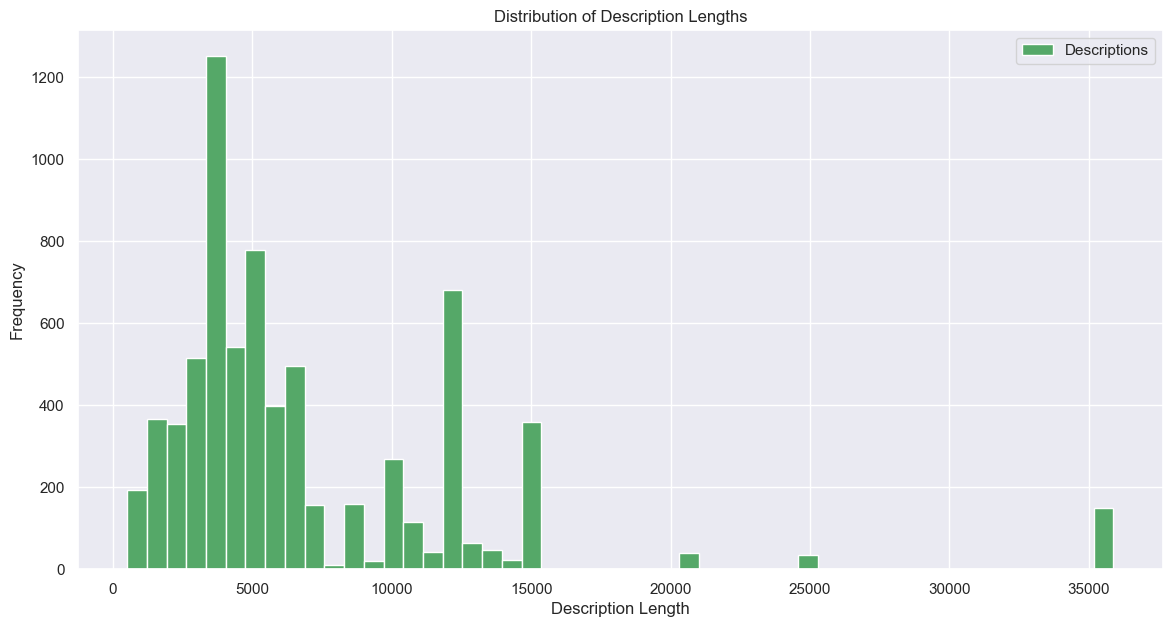

In [9]:
# Calculate the lengths of each description
description_lengths_train = np.array([len(description) for description in X_train])

# Compute min, max, and mean lengths for each category
description_min = np.min(description_lengths_train)
description_max = np.max(description_lengths_train)
description_mean = np.mean(description_lengths_train)

# Print the results
print(f"Description - Min length: {description_min}, Max length: {description_max}, Mean length: {description_mean:.2f}")

# Create histograms
plt.figure(figsize=(14, 7))

plt.hist(description_lengths_train, bins=50, color='g', label='Descriptions')

plt.title('Distribution of Description Lengths')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

# Data Processing

In [10]:
# def get_word_index(dataframe):
#     """
#     Build a word index from a pandas DataFrame column containing text data.

#     Parameters:
#     dataframe (pd.DataFrame): The DataFrame containing text data.

#     Returns:
#     dict: A dictionary mapping words to unique integer indices.
#     """
#     # Tokenize the text data
#     text_data = dataframe.astype(str).tolist()
#     tokenized_text = [word for text in text_data for word in text.split()]

#     # Build a vocabulary
#     word_counts = Counter(tokenized_text)
#     vocabulary = word_counts.keys()

#     # Assign a unique index to each word
#     word_index = {word: idx for idx, word in enumerate(vocabulary, start=1)}

#     return word_index

def get_word_index(texts, important_words, stop_words):
    # Tokenize the text data and remove stop words
    tokenized_text = [word for text in texts for word in text.split() if word not in stop_words]
    
    # Count word frequencies
    word_counts = Counter(tokenized_text)
    
    # Create word index based on frequency but prioritize important words
    word_index = {}
    current_id = 1
    
    # Assign IDs to important words first
    for word in important_words:
        if word not in word_index:
            word_index[word] = current_id
            current_id += 1
    
    # Assign IDs to the rest of the words based on frequency
    for word, _ in word_counts.most_common():
        if word not in word_index:
            word_index[word] = current_id
            current_id += 1
    
    return word_index

# Set the index of words by frequency they occur.
Y_train_classes = np.concatenate((make_classes, model_classes, year_classes))
important_words = set(Y_train_classes.astype(str).flatten())
word_index = get_word_index(X_train, important_words, stop_words)

# Create a reverse index so we can lookup tokens assigned to each id.
reverse_index = dict([(value, key) for (key, value) in word_index.items()])
reverse_index[1] = '<START>'  # start of input
reverse_index[2] = '#'        # out-of-vocabulary (OOV)
reverse_index[3] = '<UNUSED>'

max_id = max(reverse_index.keys())
print('Largest ID:', max_id)

Largest ID: 15249


In [11]:
len(important_words)

1245

In [12]:
def decode(token_ids):
  """Return a string with the decoded text given a list of token ids."""
  # Try looking up each id in the index, but return '#' (for OOV) if not found.
  tokens = [reverse_index.get(i, "#") for i in token_ids]

  # Connect the string tokens with a space.
  return ' '.join(tokens)

In [13]:
# def text_to_sequences(texts, word_index):
#     """
#     Convert text data to sequences of integers based on the word index.

#     Parameters:
#     texts (list of str): List of text data.
#     word_index (dict): Dictionary mapping words to unique integer indices.

#     Returns:
#     list of list of int: List of sequences.
#     """
#     sequences = []
#     for text in texts:
#         # Remove punctuation and convert to lowercase
#         text = re.sub(r'[^\w\s]', '', text.lower())
#         # Tokenize text
#         words = text.split()
#         # Convert words to their respective indices
#         sequence = [word_index.get(word, 2) for word in words]  # Use 2 for OOV words
#         sequences.append(sequence)
#     return sequences

def text_to_sequences(texts, word_index, stop_words):
    sequences = []
    for text in texts:
        # text = re.sub(r'[^\w\s]', '', text.lower())
        # Lowercase and remove special characters except dashes in one step
        text = re.sub(r'[^a-z0-9\s-]', '', text.lower())
        words = text.split()
        words = [word for word in words if word not in stop_words]
        sequence = [word_index.get(word, 2) for word in words]  # Use 2 for OOV words
        sequences.append(sequence)
    return sequences

def truncate_pad_data(sequences, max_length):
    padded_data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    return padded_data

In [14]:
# Limit Vocab

# v0
# def limit_vocab(sequences, max_token_id, oov_id=2):
#   """Replace token ids greater than or equal to max_token_id with the oov_id."""
#   reduced_sequences = [[(token if token < max_token_id else oov_id) for token in sequence] for sequence in sequences]
#   return reduced_sequences

# v1
# def limit_vocab(sequences, max_token_id, oov_id=2):
#     important_tokens = {word_index[word] for word in important_words if word in word_index}
#     reduced_sequences = [[(token if token < max_token_id or token in important_tokens else oov_id) for token in sequence] for sequence in sequences]
#     return reduced_sequences

# v2
# Limit vocabulary but retain important words and remove consecutive OOV tokens
def limit_vocab(sequences, max_token_id, important_words, word_index, oov_id=2):
    important_tokens = {word_index[word] for word in important_words if word in word_index}
    reduced_sequences = []
    for sequence in sequences:
        new_sequence = []
        last_was_oov = False
        for token in sequence:
            if token < max_token_id or token in important_tokens:
                new_sequence.append(token)
                last_was_oov = False
            else:
                if not last_was_oov:
                    new_sequence.append(oov_id)
                last_was_oov = True
        reduced_sequences.append(new_sequence)
    return reduced_sequences

In [15]:
# Convert text to sequences
# sequences = text_to_sequences(X_train.tolist(), index)
sequences = text_to_sequences(X_train.tolist(), word_index, stop_words)

# Truncate and pad the sequences
max_length = 20000
X_train_padded = truncate_pad_data(sequences, max_length)

# Reduce vocabulary
max_token_id = 3500
X_train_reduced = limit_vocab(X_train_padded, max_token_id=max_token_id, important_words=important_words, word_index=word_index)

In [16]:
# Convert text to sequences
# sequences = text_to_sequences(X_train.tolist(), index)
sequences = text_to_sequences(X_val.tolist(), word_index, stop_words)

# Truncate and pad the sequences
X_val_padded = truncate_pad_data(sequences, max_length)

# Reduce vocabulary
X_val_reduced = limit_vocab(X_val_padded, max_token_id=max_token_id , important_words=important_words, word_index=word_index)

In [17]:
# Convert to sparse matrix for one-hot encoding
def to_sparse_one_hot(sequences, vocab_size):
    row_indices = []
    col_indices = []
    data = []
    for i, sequence in enumerate(sequences):
        for j, token in enumerate(sequence):
            if token > 0:
                row_indices.append(i)
                col_indices.append(token)
                data.append(1)
    return csr_matrix((data, (row_indices, col_indices)), shape=(len(sequences), vocab_size))


In [18]:
# One-hot encoding
# X_train_one_hot = tf.keras.utils.to_categorical(X_train_reduced)
vocab_size = max_token_id
X_train_one_hot = to_sparse_one_hot(X_train_reduced, vocab_size)
X_val_one_hot = to_sparse_one_hot(X_val_reduced, vocab_size)

# Check the output
print('Length of original sequence:', len(sequences[0]))
print('Length of padded sequence:', len(X_train_padded[0]))
print('First padded sequence:', X_train_padded[0])
print('First reduced sequence:', X_train_reduced[0])
print('Decoded reduced sequence:', decode(X_train_reduced[0]))
print('One-hot encoded shape:', X_train_one_hot.shape)

Length of original sequence: 674
Length of padded sequence: 20000
First padded sequence: [2514 1663 1898 ...    0    0    0]
First reduced sequence: [2514, 1663, 1898, 3480, 1328, 3169, 2, 2551, 1250, 1372, 1250, 2514, 1250, 2419, 2, 1250, 1824, 2495, 2, 1427, 2, 2259, 2, 1728, 1042, 2, 2, 2, 2, 2, 1968, 2, 1663, 1898, 3480, 1328, 3169, 2, 2169, 2643, 1303, 2259, 2, 1728, 1042, 2, 2208, 1413, 2, 2202, 1372, 2, 1585, 2, 1452, 1250, 1381, 1748, 1691, 2179, 2, 3169, 2, 1898, 3480, 1271, 1534, 1256, 1412, 1299, 1271, 1415, 1420, 1301, 1308, 1313, 1344, 1406, 2, 1303, 2562, 1372, 1285, 1297, 1271, 1355, 1308, 2318, 1359, 1845, 1256, 2438, 2647, 1363, 2861, 1497, 1373, 2862, 1359, 1534, 1664, 1260, 2, 1453, 2036, 1702, 1356, 1938, 1410, 1326, 1250, 1496, 2, 1496, 1862, 2, 2, 2, 2271, 1356, 1513, 2382, 1776, 1250, 2529, 1662, 2066, 2373, 1250, 1360, 2, 1246, 2075, 1326, 1250, 1816, 1452, 2, 2107, 1410, 2, 2, 1246, 1822, 1791, 1326, 1250, 2327, 1452, 1905, 1410, 2, 2, 2, 1246, 2387, 1791, 1326

# Train Model

In [19]:
X_train_reduced = X_train_one_hot.toarray()
type(X_train_reduced)

numpy.ndarray

In [20]:
print("Type of X_train_reduced:", type(X_train_reduced))
print("Data type of elements in X_train_reduced:", X_train_reduced.dtype)
print("Shape of X_train_reduced:", X_train_reduced.shape)
print("First element of X_train_reduced:", X_train_reduced[0])

Type of X_train_reduced: <class 'numpy.ndarray'>
Data type of elements in X_train_reduced: int32
Shape of X_train_reduced: (7066, 3500)
First element of X_train_reduced: [ 0  0 54 ...  0  0  0]


In [21]:
# # print(f'Train index: {Y_train_idx}')
print(f'X_train: {X_train.shape}')
print(f'Y_train_year: {Y_train_year_over.shape}')
print(f'Y_train_make: {Y_train_make_over.shape}')
print(f'Y_train_model: {Y_train_model_over.shape}')
# print(f'Val index: {Y_val_idx}')
print(f'X_val: {X_val.shape}')
print(f'Y_val_year: {Y_val_year.shape}')
print(f'Y_val_make: {Y_val_make.shape}')
print(f'Y_val_model: {Y_val_model.shape}')
# print(f'Test index: {Y_test_idx}')
print(f'X_test: {X_test.shape}')
print(f'Y_test_year: {Y_test_year.shape}')
print(f'Y_test_make: {Y_test_make.shape}')
print(f'Y_test_model: {Y_test_model.shape}')

X_train: (7066,)
Y_train_year: (7066, 93)
Y_train_make: (7066, 104)
Y_train_model: (7066, 1053)
X_val: (503,)
Y_val_year: (503, 93)
Y_val_make: (503, 104)
Y_val_model: (503, 1053)
X_test: (500,)
Y_test_year: (500, 93)
Y_test_make: (500, 104)
Y_test_model: (500, 1053)


In [22]:
# display classes
def k_hot_to_dense(k_hot_encoded):
    """
    Convert k-hot encoded vectors to dense vectors.

    Args:
        k_hot_encoded (numpy.ndarray): A 2D numpy array where each row is a k-hot encoded vector.

    Returns:
        list of lists: Each sublist contains the indices of the 1s for the corresponding k-hot encoded vector.
    """
    dense_vectors = []
    for k_hot in k_hot_encoded:
        dense_vector = np.where(k_hot == 1)[0].tolist()
        dense_vectors.append(dense_vector)
    return dense_vectors

def extract_class_names(values_list, indices_list):
    return [[[values_list[i]] for i in indices] for indices in indices_list]

In [46]:
# complex accuracy
# best_thresholds, best_accuracy

# per article: https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea
# per article: https://www.linkedin.com/pulse/hamming-score-multi-label-classification-chandra-sharat/
# micro = TP + FN + FP
# macro: calculate metrics and find unweighted mean
# weighted: calculate metrics and find weighted mean

def default_threshold(arr, threshold=0.5):
    # Convert the array to a NumPy array if it is not already one
    arr = np.array(arr)
    # Apply the threshold
    arr[arr < threshold] = 0
    arr[arr >= threshold] = 1
    return arr


def find_best_threshold_multilabel(y_true, y_pred_proba, metric='accuracy'):
    """
    Find the best threshold for multi-label classification predictions to maximize accuracy.

    Args:
        y_true: Array-like, shape (n_samples, n_classes), true binary labels (0 or 1).
        y_pred_proba: Array-like, shape (n_samples, n_classes), predicted probabilities from the model.
        metric: String, choose the metric you would like to find the best threshold for

    Returns:
        best_thresholds: List of floats, the thresholds that give the highest accuracy for each class.
        best_accuracies: List of floats, the highest accuracy scores for each class.
    """
    n_classes = y_true.shape[1]
    best_thresholds = []
    best_scores = []

    # Select metric:
    if metric == 'fl_score':
        score_function = lambda y_true, y_pred: f1_score(y_true, y_pred, zero_division=np.nan)
    elif metric == 'precision':
        score_function = lambda y_true, y_pred: precision_score(y_true, y_pred, zero_division=np.nan)
    elif metric == 'recall':
        score_function = lambda y_true, y_pred: recall_score(y_true, y_pred, zero_division=np.nan)
    elif metric == 'accuracy':
        score_function = accuracy_score
    else:
        raise ValueError("Metric should be 'accuracy', 'f1_score', 'precision', or 'recall'.")


    # Iterate through each class
    for i in range(n_classes):
        best_threshold = 0.0
        best_score = 0.0

        # Iterate through possible threshold values from 0 to 1
        for threshold in np.arange(0.00001, 1.00001, 0.0001):
            y_pred = (y_pred_proba[:, i] >= threshold).astype(int)
            score = score_function(y_true[:, i], y_pred)

            if score > best_score:
                best_score = score
                best_threshold = threshold

        best_thresholds.append(best_threshold)
        best_scores.append(best_score)

    return best_thresholds, best_scores


def apply_best_thresholds(y_pred_proba, best_thresholds):
    """
    Apply the best thresholds to convert predicted probabilities to binary predictions.

    Args:
        y_pred_proba: Array-like, shape (n_samples, n_classes), predicted probabilities from the model.
        best_thresholds: List of floats, the thresholds that give the highest accuracy for each class.

    Returns:
        y_pred_binary: Array-like, shape (n_samples, n_classes), binary predictions after applying thresholds.
    """
    y_pred_binary = np.zeros_like(y_pred_proba)

    for i, threshold in enumerate(best_thresholds):
        y_pred_binary[:, i] = (y_pred_proba[:, i] >= threshold).astype(int)

    return y_pred_binary

def metric_evaluations(y_true, y_pred, y_pred_best):
    """Enter X, y_true, and y_pred. Returns before, after, and final predictions as outputs.
    Args:
        threshold = 'accuracy', 'f1_score', 'precision', or 'recall'
    """

    # Before
    before_metrics = {}
    before_metrics['precision_micro'] = precision_score(y_true, y_pred, average='micro', zero_division=np.nan)
    before_metrics['precision_weighted'] = precision_score(y_true, y_pred, average='weighted', zero_division=np.nan)
    before_metrics['recall_micro'] = recall_score(y_true, y_pred, average='micro', zero_division=np.nan)
    before_metrics['recall_weighted'] = recall_score(y_true, y_pred, average='weighted', zero_division=np.nan)
    before_metrics['f1_score_micro'] = f1_score(y_true, y_pred, average='micro', zero_division=np.nan)
    before_metrics['f1_score_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=np.nan)
    # before_metrics['roc_auc_score_micro'] = roc_auc_score(y_true, y_pred, average='micro')
    # before_metrics['roc_auc_score_weighted'] = roc_auc_score(y_true, y_pred, average='weighted')
    # before_metrics['hamming_loss'] = hamming_loss(y_true, y_pred)
    before_metrics['accuracy'] = accuracy_score(y_true, y_pred)

    # After
    after_metrics = {}
    after_metrics['precision_micro'] = precision_score(y_true, y_pred_best, average='micro', zero_division=np.nan)
    after_metrics['precision_weighted'] = precision_score(y_true, y_pred_best, average='weighted', zero_division=np.nan)
    after_metrics['recall_micro'] = recall_score(y_true, y_pred_best, average='micro', zero_division=np.nan)
    after_metrics['recall_weighted'] = recall_score(y_true, y_pred_best, average='weighted', zero_division=np.nan)
    after_metrics['f1_score_micro'] = f1_score(y_true, y_pred_best, average='micro', zero_division=np.nan)
    after_metrics['f1_score_weighted'] = f1_score(y_true, y_pred_best, average='weighted', zero_division=np.nan)
    # after_metrics['roc_auc_score_micro'] = roc_auc_score(y_true, y_pred_best, average='micro')
    # after_metrics['roc_auc_score_weighted'] = roc_auc_score(y_true, y_pred_best, average='weighted')
    # after_metrics['hamming_loss'] = hamming_loss(y_true, y_pred_best)
    after_metrics['accuracy'] = accuracy_score(y_true, y_pred_best)

    return before_metrics, after_metrics


Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 1.0262 - make_output_accuracy: 0.0223 - model_output_accuracy: 0.0306 - year_output_accuracy: 0.0239 - val_loss: 0.3437 - val_make_output_accuracy: 0.1252 - val_model_output_accuracy: 0.0835 - val_year_output_accuracy: 0.0517 - learning_rate: 0.0010
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.3646 - make_output_accuracy: 0.0704 - model_output_accuracy: 0.0943 - year_output_accuracy: 0.0296 - val_loss: 0.3394 - val_make_output_accuracy: 0.1233 - val_model_output_accuracy: 0.0835 - val_year_output_accuracy: 0.0417 - learning_rate: 0.0010
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.3478 - make_output_accuracy: 0.0782 - model_output_accuracy: 0.0943 - year_output_accuracy: 0.0345 - val_loss: 0.3418 - val_make_output_accuracy: 0.1213 - val_model_output_accuracy: 0.0835 - val_year_output_accuracy: 0.0358 - learning_rate: 0.0010
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.337

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3500)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 3500, 2)   │      7,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 7000)      │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,792,256 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ year_output (Dense) │ (None, 93)        │     11,997 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ make_output (Dense) │ (None, 104)       │     13,416 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_output        │ (None, 1053)      │    135,837 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,980,208 (22.81 MB)

 Trainable params: 1,993,402 (7.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,986,806 (15.21 MB)

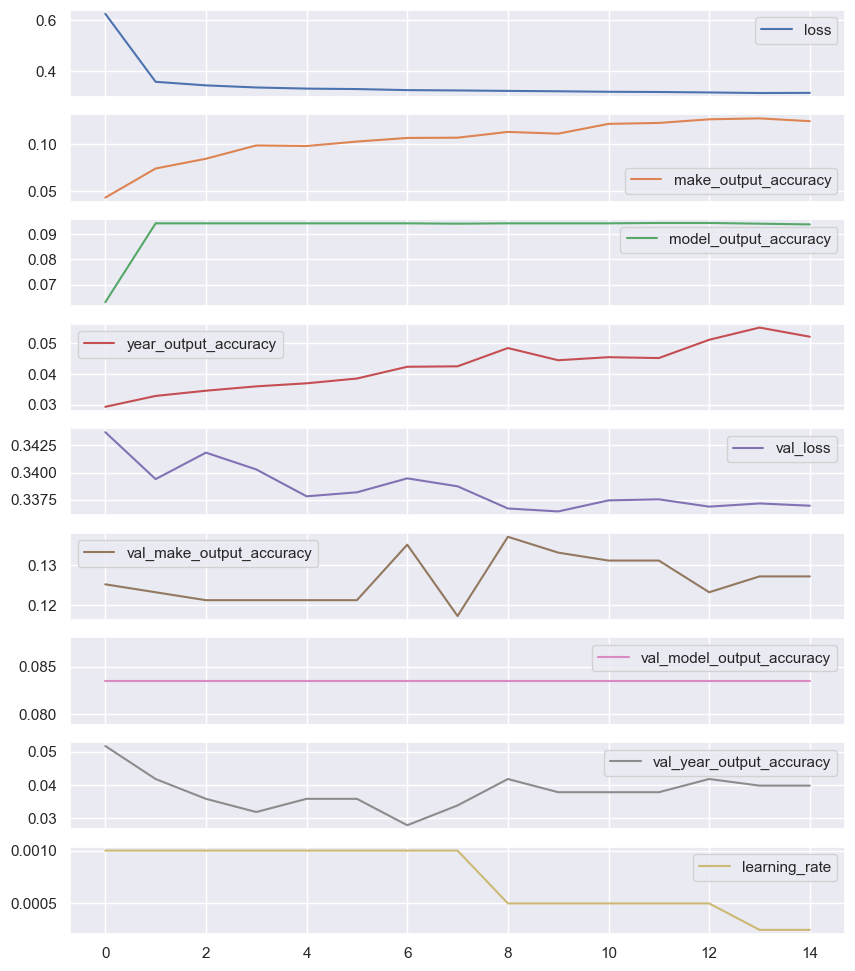

In [24]:
def build_multi_output_model(vocab_size=vocab_size, sequence_length=max_token_id, embedding_dim=2,
                             num_year_classes=len(year_classes),
                             num_make_classes=len(make_classes),
                             num_model_classes=len(model_classes),
                             learning_rate=0.01):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    input_layer = tf.keras.layers.Input(shape=(sequence_length,))
    embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)
    flatten_layer = tf.keras.layers.Flatten()(embedding_layer)
    
    # Additional layers for complexity and regularization
    dense_layer_1 = tf.keras.layers.Dense(256, activation='relu')(flatten_layer)
    dropout_layer_1 = Dropout(0.5)(dense_layer_1)
    dense_layer_2 = tf.keras.layers.Dense(128, activation='relu')(dropout_layer_1)
    dropout_layer_2 = Dropout(0.5)(dense_layer_2)
    # dense_layer_3 = tf.keras.layers.Dense(64, activation='relu')(dropout_layer_2)
    # dropout_layer_3 = Dropout(0.5)(dense_layer_3)
    
    year_output = tf.keras.layers.Dense(units=num_year_classes, activation='sigmoid', name='year_output')(dropout_layer_2)
    make_output = tf.keras.layers.Dense(units=num_make_classes, activation='sigmoid', name='make_output')(dropout_layer_2)
    model_output = tf.keras.layers.Dense(units=num_model_classes, activation='sigmoid', name='model_output')(dropout_layer_2)
    
    model = tf.keras.Model(inputs=input_layer, outputs=[year_output, make_output, model_output])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer,
                  metrics=['accuracy', 'accuracy', 'accuracy'])
    
    return model

# Train the multi-output model
learning_rate = 0.001
multi_output_model = build_multi_output_model(learning_rate=learning_rate)

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

history_multi = multi_output_model.fit(
    x=X_train_one_hot,  
    y={'year_output': Y_train_year_over, 'make_output': Y_train_make_over, 'model_output': Y_train_model_over},          
    epochs=50,  # Increase the number of epochs
    batch_size=64,  # Increase the batch size
    validation_data=(X_val_one_hot, {'year_output': Y_val_year, 'make_output': Y_val_make, 'model_output': Y_val_model}),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

multi_output_model.summary()

# Plot the training history for each output
history_multi_df = pd.DataFrame(history_multi.history)
history_multi_df.plot(subplots=True, figsize=(10, 12))

plt.show()

In [25]:
val_predictions = multi_output_model.predict(X_val_one_hot)
len(val_predictions[0])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


503

In [26]:
val_predictions_year = np.array(val_predictions[0])
val_predictions_make = np.array(val_predictions[1])
val_predictions_model = np.array(val_predictions[2])
val_predictions_make.shape

(503, 104)

In [38]:
val_predictions_make[:3]

array([[1.70794432e-04, 2.72234785e-04, 1.77752646e-03, 2.53744107e-02,
        2.51270860e-04, 4.05314495e-05, 6.27867921e-05, 7.79156762e-05,
        1.82615127e-02, 1.90413135e-04, 3.08509357e-02, 2.62879650e-04,
        1.52742708e-04, 4.13623936e-02, 2.39297990e-02, 1.03961218e-04,
        1.18745171e-04, 1.58355981e-01, 3.68772447e-02, 5.45239855e-05,
        3.30285286e-04, 1.57729001e-03, 2.33401638e-03, 2.84722541e-04,
        1.15599282e-01, 3.02049308e-03, 7.05483180e-05, 1.57048780e-05,
        2.09882070e-04, 3.30220122e-04, 1.20032855e-04, 7.90153514e-04,
        1.52218431e-01, 1.23765098e-03, 1.02748536e-01, 1.10823690e-04,
        3.96532851e-04, 2.50971410e-03, 6.04319612e-05, 3.56874317e-02,
        1.03284949e-02, 4.16719813e-05, 2.89414842e-02, 2.38705352e-02,
        4.44803294e-03, 4.65778685e-05, 1.09806275e-02, 4.47936775e-03,
        3.90271246e-02, 3.32050840e-04, 6.63392348e-05, 2.94631667e-04,
        2.46745031e-02, 1.31699577e-04, 9.69610270e-03, 2.549478

In [27]:
np.save(os.path.join(base_path, 'outputs/Y_val_year_pred'), val_predictions_year)
np.save(os.path.join(base_path, 'outputs/Y_val_make_pred'), val_predictions_make)
np.save(os.path.join(base_path, 'outputs/Y_val_model_pred'), val_predictions_model)

In [58]:
best_thresholds_make, best_f1_score_make = find_best_threshold_multilabel(Y_val_make, val_predictions_make, metric='accuracy')
y_pred_best = apply_best_thresholds(val_predictions_make, best_thresholds_make)
y_pred = default_threshold(val_predictions_make)
Y_val_make_pred_metrics = metric_evaluations(Y_val_make, y_pred, y_pred_best)
print("Y_val_make_pred_metrics", Y_val_make_pred_metrics)

best_thresholds_model, best_f1_score_model = find_best_threshold_multilabel(Y_val_model, val_predictions_model, metric='accuracy')
y_pred_best = apply_best_thresholds(val_predictions_model, best_thresholds_model)
y_pred = default_threshold(val_predictions_model)
Y_val_model_pred_metrics = metric_evaluations(Y_val_model, y_pred, y_pred_best)
print("Y_val_model_pred_metrics", Y_val_model_pred_metrics)

best_thresholds_year, best_f1_score_year = find_best_threshold_multilabel(Y_val_year, val_predictions_make, metric='accuracy')
y_pred_best = apply_best_thresholds(val_predictions_year, best_thresholds_year)
y_pred = default_threshold(val_predictions_year)
Y_val_year_pred_metrics = metric_evaluations(Y_val_year, y_pred, y_pred_best)
print("Y_val_year_pred_metrics", Y_val_year_pred_metrics)

Y_val_make_pred_metrics ({'precision_micro': nan, 'precision_weighted': nan, 'recall_micro': 0.0, 'recall_weighted': 0.0, 'f1_score_micro': 0.0, 'f1_score_weighted': 0.0, 'accuracy': 0.0}, {'precision_micro': 0.574468085106383, 'precision_weighted': 0.5917569193742479, 'recall_micro': 0.03146853146853147, 'recall_weighted': 0.03146853146853147, 'f1_score_micro': 0.05966850828729282, 'f1_score_weighted': 0.05425454016626758, 'accuracy': 0.0019880715705765406})
Y_val_model_pred_metrics ({'precision_micro': nan, 'precision_weighted': nan, 'recall_micro': 0.0, 'recall_weighted': 0.0, 'f1_score_micro': 0.0, 'f1_score_weighted': 0.0, 'accuracy': 0.0}, {'precision_micro': 0.5052631578947369, 'precision_weighted': 0.5072877059569074, 'recall_micro': 0.05102763997165131, 'recall_weighted': 0.05102763997165131, 'f1_score_micro': 0.09269391696169939, 'f1_score_weighted': 0.0605027640286322, 'accuracy': 0.0019880715705765406})
Y_val_year_pred_metrics ({'precision_micro': nan, 'precision_weighted':

In [59]:
y_pred_best[:3]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        0., 1.

In [60]:
best_thresholds

[0.00501,
 0.00541,
 0.03381000000000001,
 0.06631,
 0.00601,
 0.0021100000000000003,
 0.00271,
 0.00271,
 0.058910000000000004,
 0.00501,
 0.10441,
 0.0046099999999999995,
 0.00411,
 0.09821,
 0.09821,
 0.00271,
 0.0034100000000000003,
 0.21741000000000002,
 0.10191,
 0.0021100000000000003,
 0.00571,
 0.03291,
 0.08441,
 0.0049099999999999994,
 0.17411000000000001,
 0.020210000000000002,
 0.00221,
 0.0013100000000000002,
 0.00451,
 0.00571,
 0.00391,
 0.00941,
 0.22681,
 0.01521,
 0.18051000000000003,
 0.00301,
 0.00781,
 0.03341,
 0.00231,
 0.10731,
 0.037610000000000005,
 0.0018100000000000002,
 0.11461,
 0.06981,
 0.038810000000000004,
 0.0021100000000000003,
 0.046110000000000005,
 0.04351000000000001,
 0.12721000000000002,
 0.00521,
 0.00251,
 0.00551,
 0.10831,
 0.00321,
 0.05521000000000001,
 0.06351,
 0.09801,
 0.0024100000000000002,
 0.00471,
 0.03141000000000001,
 0.00551,
 0.00401,
 0.07841,
 0.10741,
 0.07821,
 0.0034100000000000003,
 0.01451,
 0.12111,
 0.00371,
 0.00271,

In [61]:
train_predictions = multi_output_model.predict(X_train_one_hot)
train_predictions_year = np.array(train_predictions[0])
train_predictions_make = np.array(train_predictions[1])
train_predictions_model = np.array(train_predictions[2])

np.save(os.path.join(base_path, 'outputs/Y_train_year_pred'), train_predictions_year)
np.save(os.path.join(base_path, 'outputs/Y_train_make_pred'), train_predictions_make)
np.save(os.path.join(base_path, 'outputs/Y_train_model_pred'), train_predictions_model)

221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


# Test

In [62]:
# Convert text to sequences
# sequences = text_to_sequences(X_train.tolist(), index)
sequences = text_to_sequences(X_test.tolist(), word_index, stop_words)

# Truncate and pad the sequences
X_test_padded = truncate_pad_data(sequences, max_length)

# Reduce vocabulary
X_test_reduced = limit_vocab(X_test_padded, max_token_id=max_token_id, important_words=important_words, word_index=word_index)

X_test_one_hot = to_sparse_one_hot(X_test_reduced, vocab_size)

In [63]:
test_predictions = multi_output_model.predict(X_test_one_hot)
len(test_predictions[0])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


500

In [64]:
test_predictions_year = np.array(test_predictions[0])
test_predictions_make = np.array(test_predictions[1])
test_predictions_model = np.array(test_predictions[2])
print(test_predictions_year.shape)
print(test_predictions_make.shape)
print(test_predictions_model.shape)

(500, 93)
(500, 104)
(500, 1053)


In [65]:
np.save(os.path.join(base_path, 'outputs/Y_test_year_pred'), test_predictions_year)
np.save(os.path.join(base_path, 'outputs/Y_test_make_pred'), test_predictions_make)
np.save(os.path.join(base_path, 'outputs/Y_test_model_pred'), test_predictions_model)

In [66]:
# best_thresholds, best_f1_score = find_best_threshold_multilabel(Y_test_make, test_predictions_make, metric='accuracy')
y_pred_best_make = apply_best_thresholds(test_predictions_make, best_thresholds_make)
y_pred_make = default_threshold(test_predictions_make)
Y_test_make_pred_metrics = metric_evaluations(Y_test_make, y_pred_make, y_pred_best_make)
print("Y_test_make_pred_metrics", Y_test_make_pred_metrics)

# best_thresholds, best_f1_score = find_best_threshold_multilabel(Y_test_model, test_predictions_model, metric='accuracy')
y_pred_best_model = apply_best_thresholds(test_predictions_model, best_thresholds_model)
y_pred_model = default_threshold(test_predictions_model)
Y_test_model_pred_metrics = metric_evaluations(Y_test_model, y_pred_model, y_pred_best_model)
print("Y_test_model_pred_metrics", Y_test_model_pred_metrics)

# best_thresholds, best_f1_score = find_best_threshold_multilabel(Y_test_year, test_predictions_make, metric='accuracy')
y_pred_best_year = apply_best_thresholds(test_predictions_year, best_thresholds_year)
y_pred_year = default_threshold(test_predictions_year)
Y_test_year_pred_metrics = metric_evaluations(Y_test_year, y_pred_year, y_pred_best_year)
print("Y_test_year_pred_metrics", Y_test_year_pred_metrics)

Y_test_make_pred_metrics ({'precision_micro': nan, 'precision_weighted': nan, 'recall_micro': 0.0, 'recall_weighted': 0.0, 'f1_score_micro': 0.0, 'f1_score_weighted': 0.0, 'accuracy': 0.0}, {'precision_micro': 0.09230769230769231, 'precision_weighted': 0.14921497584541063, 'recall_micro': 0.01411764705882353, 'recall_weighted': 0.01411764705882353, 'f1_score_micro': 0.024489795918367346, 'f1_score_weighted': 0.023356203778358522, 'accuracy': 0.0})
Y_test_model_pred_metrics ({'precision_micro': nan, 'precision_weighted': nan, 'recall_micro': 0.0, 'recall_weighted': 0.0, 'f1_score_micro': 0.0, 'f1_score_weighted': 0.0, 'accuracy': 0.0}, {'precision_micro': 0.006402048655569782, 'precision_weighted': 0.009612724757952974, 'recall_micro': 0.0017985611510791368, 'recall_weighted': 0.0017985611510791368, 'f1_score_micro': 0.002808199943836001, 'f1_score_weighted': 0.001664382779490693, 'accuracy': 0.0})
Y_test_year_pred_metrics ({'precision_micro': nan, 'precision_weighted': nan, 'recall_mic

In [67]:
# move down
dense_vector = k_hot_to_dense(y_pred_best_model)
dense_names = extract_class_names(model_classes, dense_vector)
dense_true_vector = k_hot_to_dense(Y_test_model)
true_names = extract_class_names(model_classes, dense_true_vector)
print(len(X_test_idx), len(dense_names), len(true_names))
comparison_df = pd.DataFrame({'Index': X_test_idx, 'Predicted': dense_names, 'Target': true_names})
comparison_df

500 500 500


,Index,Predicted,Target
0,2,[],[[Altima]]
1,3,[],[[Mustang]]
2,8,[],[[OtherModel]]
3,22,[],"[[9-7x], [Ascender], [Bravada], [Canyon], [Col..."
4,34,[],[[Encore]]
...,...,...,...
495,4970,[],"[[A4], [A6], [A8 Quattro], [Beetle], [Golf], [..."
496,4973,[],[[OtherModel]]
497,4975,[],[[B2200]]
498,4992,[],"[[325i], [330i], [525i], [530i], [Z4]]"


In [68]:
comparison_df.to_csv('./outputs/comparison_model.csv')

In [69]:
# move down
dense_vector = k_hot_to_dense(y_pred_best_make)
dense_names = extract_class_names(make_classes, dense_vector)
dense_true_vector = k_hot_to_dense(Y_test_make)
true_names = extract_class_names(make_classes, dense_true_vector)
print(len(X_test_idx), len(dense_names), len(true_names))
comparison_df = pd.DataFrame({'Index': X_test_idx, 'Predicted': dense_names, 'Target': true_names})
comparison_df.to_csv('./outputs/comparison_make.csv')
comparison_df

500 500 500


,Index,Predicted,Target
0,2,[],[[Nissan]]
1,3,[],[[Ford]]
2,8,[],[[International Harvester]]
3,22,[],"[[Buick], [Chevrolet], [GMC], [Hummer], [Isuzu..."
4,34,[],[[Buick]]
...,...,...,...
495,4970,[],"[[Audi], [Volkswagen]]"
496,4973,[],[[Volvo]]
497,4975,[],[[Mazda]]
498,4992,[],[[BMW]]


In [70]:
comparison_df[comparison_df.Predicted!='[]']

,Index,Predicted,Target
0,2,[],[[Nissan]]
1,3,[],[[Ford]]
2,8,[],[[International Harvester]]
3,22,[],"[[Buick], [Chevrolet], [GMC], [Hummer], [Isuzu..."
4,34,[],[[Buick]]
...,...,...,...
495,4970,[],"[[Audi], [Volkswagen]]"
496,4973,[],[[Volvo]]
497,4975,[],[[Mazda]]
498,4992,[],[[BMW]]


In [71]:
# move down
dense_vector = k_hot_to_dense(y_pred_best_year)
dense_names = extract_class_names(year_classes, dense_vector)
dense_true_vector = k_hot_to_dense(Y_test_year)
true_names = extract_class_names(year_classes, dense_true_vector)
print(len(X_test_idx), len(dense_names), len(true_names))
comparison_df = pd.DataFrame({'Index': X_test_idx, 'Predicted': dense_names, 'Target': true_names})
comparison_df.to_csv('./outputs/comparison_year.csv')
comparison_df

500 500 500


,Index,Predicted,Target
0,2,"[[1951], [1955], [1958], [1959], [1960], [1961...",[[2018]]
1,3,"[[1951], [1955], [1958], [1959], [1960], [1961...",[[1983]]
2,8,"[[1951], [1955], [1958], [1959], [1960], [1961...",[[1957]]
3,22,"[[1955], [1958], [1959], [1960], [1961], [1962...","[[2002], [2003], [2004], [2005], [2006], [2007..."
4,34,"[[1955], [1958], [1959], [1960], [1961], [1962...",[[2018]]
...,...,...,...
495,4970,"[[1951], [1955], [1958], [1959], [1960], [1961...","[[1999], [2000], [2001], [2002], [2003], [2004]]"
496,4973,"[[1951], [1955], [1958], [1959], [1960], [1961...","[[2015], [2016]]"
497,4975,"[[1951], [1955], [1958], [1959], [1960], [1961...","[[1987], [1988], [1989], [1990], [1991], [1992..."
498,4992,"[[1948], [1951], [1952], [1955], [1958], [1959...","[[2006], [2007]]"
